In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import torchmetrics

# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

3 séances de TP sur ce sujet : le 15 novembre (1h00), le 22 novembre (3h) et le 29 novembre (3h).<br>
Deadline : 6 décembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

<font color="blue"> David FAGET CAÑO

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétiques comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:
1/ Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2/ Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3/ Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".


## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

--------------------------------------------------------------------------------
<font color="blue"> Dans cette première cellule, je voudrais faire deux observations:

<font color="blue">1- Tous les commentaires et explications sont en bleu. Les consignes sont en noir.

<font color="blue"> 2- C'est la première fois que j'utilise PyTorch.

<font color="blue"> Pour commencer ce TP, nous allons charger les données que nous utiliserons dans ce travail. Puisque ce notebook a été réalisé sur Google Colab, nous pouvons importer les données depuis Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Chemins des fichiers pour chaque ensemble
train_path = "/content/drive/MyDrive/TP3/train.hdf5"
validation_path = "/content/drive/MyDrive/TP3/validation.hdf5"
test_path = "/content/drive/MyDrive/TP3/test.hdf5"
samples_path = "/content/drive/MyDrive/TP3/samples.hdf5"

# Chargement des données d'entraînement
train_data = h5py.File(train_path, 'r')
train_signals = np.array(train_data['signaux'])
train_snr = np.array(train_data['snr'])
train_labels_id = np.array(train_data['labels'])

# Chargement des données de validation
validation_data = h5py.File(validation_path, 'r')
validation_signals = np.array(validation_data['signaux'])
validation_snr = np.array(validation_data['snr'])
validation_labels_id = np.array(validation_data['labels'])

# Chargement des données de test
test_data = h5py.File(test_path, 'r')
test_signals = np.array(test_data['signaux'])
test_snr = np.array(test_data['snr'])
test_labels_id = np.array(test_data['labels'])

# Chargement des données pour l'ensemble samples
samples_data = h5py.File(samples_path, 'r')
samples_signals = np.array(samples_data['signaux'])
samples_snr = np.array(samples_data['snr'])
samples_labels_id = np.array(samples_data['labels'])

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [6]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }


# Utilisation:

label_name_mapping = get_labels(samples_data)

for label, name in label_name_mapping.items():
    print(f"Label: {label}, Standard Transmitter: {name}")

Label: 1, Standard Transmitter: N-PSK8
Label: 0, Standard Transmitter: N-QAM16
Label: 2, Standard Transmitter: N-QPSK
Label: 4, Standard Transmitter: W-PSK8-V1
Label: 5, Standard Transmitter: W-PSK8-V2
Label: 3, Standard Transmitter: W-QAM16


### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

<font color="blue"> Nous commençons par observer la taille des données:

In [ ]:
print("\nDonnées samples:")
print("Taille des signaux:", samples_signals.shape)
print("Taille des SNR:", samples_snr.shape)
print("Taille des labels:", samples_labels_id.shape)

print("\nDonnées d'entrainement:")
print("Taille des signaux:", train_signals.shape)
print("Taille des SNR:", train_snr.shape)
print("Taille des labels:", train_labels_id.shape)

print("\nDonnées de validation:")
print("Taille des signaux:", validation_signals.shape)
print("Taille des SNR:", validation_snr.shape)
print("Taille des labels:", validation_labels_id.shape)

print("\nDonnées de test:")
print("Taille des signaux:", test_signals.shape)
print("Taille des SNR:", test_snr.shape)
print("Taille des labels:", test_labels_id.shape)


Données samples:
Taille des signaux: (200, 2048, 2)
Taille des SNR: (200,)
Taille des labels: (200,)

Données d'entrainement:
Taille des signaux: (30000, 2048, 2)
Taille des SNR: (30000,)
Taille des labels: (30000,)

Données de validation:
Taille des signaux: (10000, 2048, 2)
Taille des SNR: (10000,)
Taille des labels: (10000,)

Données de test:
Taille des signaux: (10000, 2048, 2)
Taille des SNR: (10000,)
Taille des labels: (10000,)


<font color="blue"> On remarque que tous les ensembles possèdent des signaux avec 2048 échantillons IQ, et pourtant avec 2 canaux. Cependant, le nombre total de signaux diffère entre les ensembles.

<font color="blue"> Observons maintenant la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement:

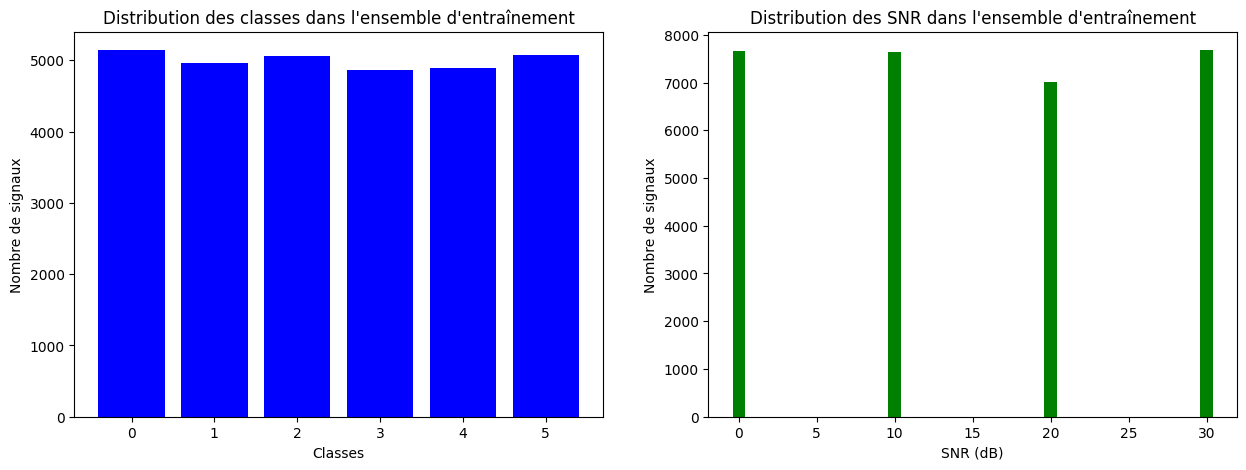

In [ ]:
# Distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement

# Distribution des classes
unique_labels_train, counts_labels_train = np.unique(train_labels_id, return_counts=True)

# Distribution oes SNR
unique_snr_train, counts_snr_train = np.unique(train_snr, return_counts=True)

# Visualisation des distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(unique_labels_train, counts_labels_train, color='blue')
plt.title('Distribution des classes dans l\'ensemble d\'entraînement')
plt.xlabel('Classes')
plt.ylabel('Nombre de signaux')

plt.subplot(1, 2, 2)
plt.bar(unique_snr_train, counts_snr_train, color='green')
plt.title('Distribution des SNR dans l\'ensemble d\'entraînement')
plt.xlabel('SNR (dB)')
plt.ylabel('Nombre de signaux')

plt.show()


<font color="blue"> Par conséquent, les signaux sont presque uniformément répartis: on trouve quasiment le même nombre de signaux pour chaque classe et pour chaque SNR.

 <font color="blue"> Finalement, nous allons visualiser quelques signaux sous forme d'onde temporelle. Pour cela, j'ai choisi d'en afficher 24 aléatoirement: un pour chaque valeur du couple (classe,SNR). </font>

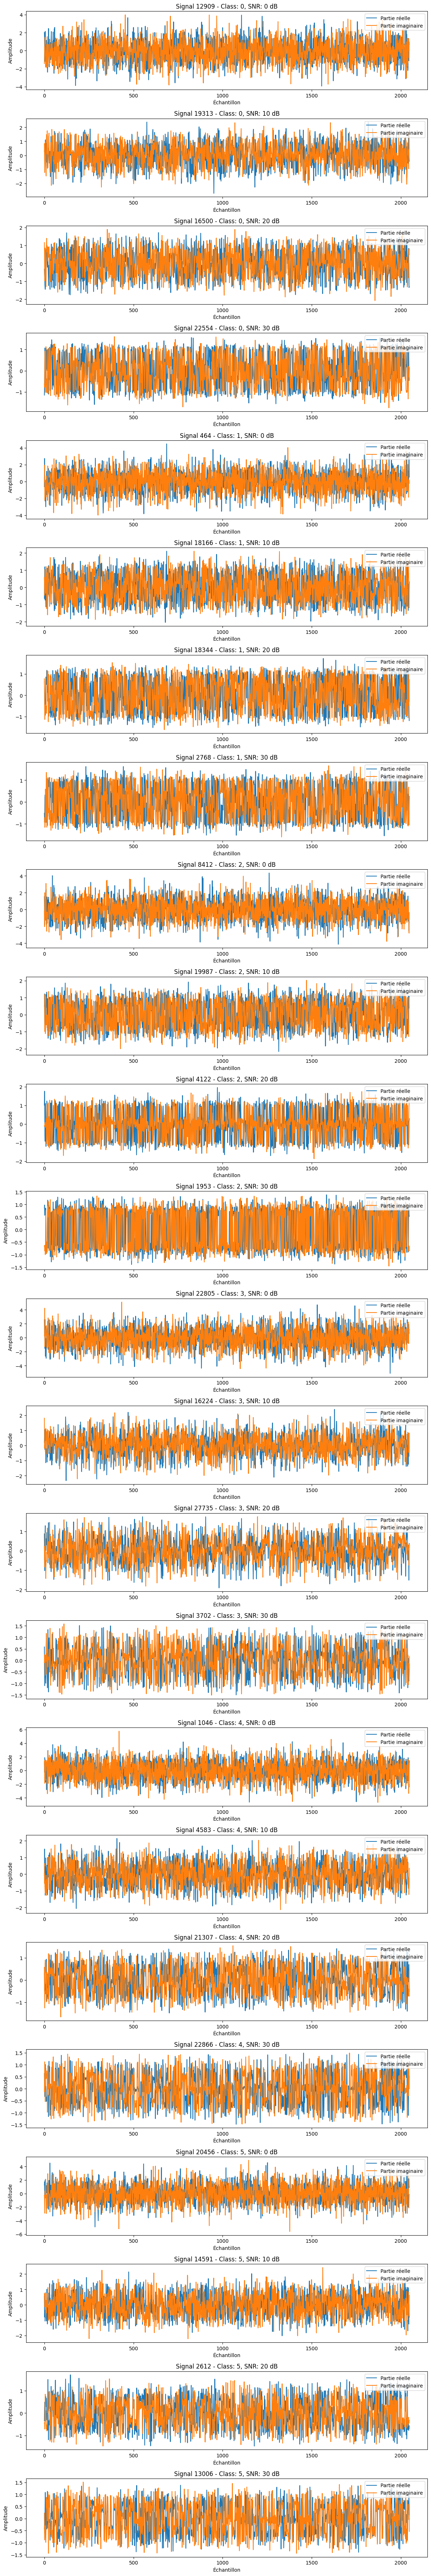

In [ ]:
num_classes_to_visualize = 6
snr_levels_to_visualize = [0, 10, 20, 30]

# Sélection aléatoire des indices pour chaque couple (classe,SNR)
random_indices_per_class_snr = []

for label in range(num_classes_to_visualize):
    for snr_level in snr_levels_to_visualize:
        indices = np.where((train_labels_id == label) & (train_snr == snr_level))[0]
        if len(indices) > 0:
            random_index = np.random.choice(indices)
            random_indices_per_class_snr.append(random_index)

# Visualisation des signaux sous forme d'onde temporelle
plt.figure(figsize=(12, 3 * (num_classes_to_visualize * len(snr_levels_to_visualize))))

for i, idx in enumerate(random_indices_per_class_snr, 1):
    plt.subplot(num_classes_to_visualize * len(snr_levels_to_visualize), 1, i)
    plt.plot(train_signals[idx,:,0], label='Partie réelle')
    plt.plot(train_signals[idx,:,1], label='Partie imaginaire')
    plt.title(f"Signal {idx} - Class: {train_labels_id[idx]}, SNR: {train_snr[idx]} dB")
    plt.xlabel("Échantillon")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<font color="blue"> A priori, avec cette représentation, on ne voit pas de différences entre les classes. Cependant, on observe une variabilité de l'amplitude selon le SNR (plus de SNR = plus d'amplitude). </font>

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [7]:
class SignalDataset(Dataset):
    def __init__(self, signals, labels, snr):
        self.signals = signals
        self.labels = labels
        self.snr = snr

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, index):
        signal = torch.tensor(self.signals[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        snr = torch.tensor(self.snr[index], dtype=torch.float32)

        return signal, label

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [8]:
# Instanciation de l'objet SignalDataset
samples_dataset = SignalDataset(signals=samples_data['signaux'], labels=samples_data['labels'], snr=samples_data['snr'])
train_dataset = SignalDataset(signals=train_data['signaux'], labels=train_data['labels'], snr=train_data['snr'])
validation_dataset = SignalDataset(signals=validation_data['signaux'], labels=validation_data['labels'], snr=validation_data['snr'])
test_dataset = SignalDataset(signals=test_data['signaux'], labels=test_data['labels'], snr=test_data['snr'])

# Test sur les données samples
example_index = 0
sample, label = samples_dataset[example_index]

# Affichage des informations
print(f"Sample Shape: {sample.shape}")
print(f"Label: {label}")

Sample Shape: torch.Size([2048, 2])
Label: 2


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [9]:
from torch.utils.data import DataLoader

dataloader = DataLoader(samples_dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [10]:
# Test du DataLoader pour 5 signaux
num_samples_to_display = 5

for i in range(num_samples_to_display):
    signal, label = samples_dataset[i]
    print(f"Signal nº {i + 1} - Classe: {label}")
    print("Signal (premières 10 valeurs):", signal[:10])
    print("\n")

# Test du DataLoader pour différentes tailles du batch (1, 2, 5, 10, 50)
batch_sizes = [1, 2, 5, 10, 50]

for batch_size in batch_sizes:
    data_loader = DataLoader(samples_dataset, batch_size=batch_size, shuffle=True)

    print(f"\nTest du DataLoader avec batch_size={batch_size}")

    for batch in data_loader:
        signals_batch, labels_batch = batch
        print(f"Taille du batch: {len(signals_batch)}")
        break  # Nous arrêtons après le premier batch

Signal nº 1 - Classe: 2
Signal (premières 10 valeurs): tensor([[-0.1976,  0.8025],
        [-0.7085,  0.3194],
        [-0.9445,  0.1932],
        [-0.2996,  0.4250],
        [-0.3676,  0.5889],
        [-0.8047,  1.1434],
        [-0.3455,  0.6690],
        [ 0.1387,  0.3764],
        [ 0.8464,  0.4646],
        [ 1.0184, -0.4678]])


Signal nº 2 - Classe: 2
Signal (premières 10 valeurs): tensor([[-0.7017, -0.5345],
        [-0.2665, -0.6631],
        [ 0.4875, -0.5817],
        [ 0.3245, -0.4205],
        [-0.5604, -0.4994],
        [-0.9194,  0.6877],
        [-1.0504, -0.2357],
        [-0.3862, -0.6927],
        [ 0.0929, -0.6714],
        [ 0.8677, -0.7082]])


Signal nº 3 - Classe: 1
Signal (premières 10 valeurs): tensor([[ 0.7766, -0.6046],
        [-0.2520, -0.4560],
        [-1.0066, -0.1191],
        [-1.1597, -0.0456],
        [-1.0142, -0.1284],
        [-0.8864, -0.2080],
        [-0.9707, -0.1415],
        [-0.9954, -0.2979],
        [-0.6478, -0.7515],
        [ 0.0016,

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

--------------------------------------------------------------------------------
<font color="blue">
Nous devons donc mettre en place un premier modèle très simple, rapide à exécuter. La première idée est de construire un modèle de classification linéaire, ce qui signifie qu'il utilise une seule couche linéaire (entièrement connectée) pour effectuer la classification.
</font>

<font color="blue">
Comme indiqué en classe, il ne faut jamais appliquer des couches denses à un signal (trop de paramètres et écrasement de la durée, c'est-à-dire qu'on ne pourra pas appliquer le même réseau de neurones à un signal de durée différente). C'est pour cela que pour le réseau plus sophistiqué présenté dans la prochaine partie, nous appliquerons des couches convolutionelles et récurrentes.
</font>

In [11]:
class SimpleModel(nn.Module):
    def __init__(self, input_channels, input_samples, num_classes):
        super(SimpleModel, self).__init__()
        # Calcul de la taille totale de l'entrée (on aplati les données)
        input_size = input_channels * input_samples
        self.fc = nn.Linear(input_size, num_classes) # Couche linéaire

    def forward(self, x):
        x = x.view(x.size(0), -1) # On aplati le tenseur
        # On applique la couche linéaire (sans fonction d'activation par simplicité)
        return torch.log_softmax(self.fc(x), dim=1)

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées

In [12]:
# Exemple d'utilisation

input_channels = 2
input_samples = 2048
num_classes = 6

# On instancie le modèle
simple_model = SimpleModel(input_channels, input_samples, num_classes)

# On teste le modèle avec un input "dummy"
dummy_input = torch.randn(10, input_channels, input_samples)  # On fixe la taille du batch à 10
output = simple_model(dummy_input)

print(simple_model)
print("Output Shape:", output.shape)

 # On vérifie que le tenseur en output possède les dimensions attendues [batch_size, num_classes]
assert output.shape == (10, num_classes), "Les dimensions de l'output ne sont pas les attendues"

SimpleModel(
  (fc): Linear(in_features=4096, out_features=6, bias=True)
)
Output Shape: torch.Size([10, 6])


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [13]:
device = 'cpu' # C'est un modèle simple: on peut l'entrainer sur la CPU.

# Hyperparamètres
input_channels = 2
input_samples = 2048
num_classes = 6
batch_size = 32
learning_rate = 0.001
n_epochs = 10
path_to_save_model = "simple_model.pth"  # Chemin pour sauvegarder le modèle entrainé

# Loss et optimisateur
criterion = nn.NLLLoss() # On utilise la log vraisemblance négative, comme indiqué dans l'énoncé
optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate)

# Création des DataLoader (attention, ces DataLoader seront aussi utilisés pour l'entrainement du réseau plus sophistiqué)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    # Phase d'entrainement
    simple_model.train()
    total_train_correct = 0
    total_train_samples = 0

    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = simple_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train_samples += batch_y.size(0)
        total_train_correct += (predicted == batch_y).sum().item()

    train_accuracy = total_train_correct / total_train_samples * 100

    # On sauvegarde la loss et l'accuracy d'entrainement pour cette epoch
    print(f'TRAIN: Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.2f}%', end="\t")

    # Phase de validation
    simple_model.eval()
    total_val_correct = 0
    total_val_samples = 0

    for batch_x, batch_y in validation_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        with torch.no_grad():
            outputs = simple_model(batch_x)
            loss = criterion(outputs, batch_y)

        _, predicted = torch.max(outputs, 1)
        total_val_samples += batch_y.size(0)
        total_val_correct += (predicted == batch_y).sum().item()

    val_accuracy = total_val_correct / total_val_samples * 100

    # On sauvegarde la loss et l'accuracy de validation pour cette epoch
    print(f'VALIDATION: Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {val_accuracy:.2f}%')

# On sauvegarde le modèle entrainé
torch.save(simple_model.state_dict(), path_to_save_model)


TRAIN: Epoch [1/10], Loss: 2.4602, Accuracy: 17.19%	VALIDATION: Epoch [1/10], Loss: 2.0003, Accuracy: 17.42%
TRAIN: Epoch [2/10], Loss: 2.1308, Accuracy: 25.42%	VALIDATION: Epoch [2/10], Loss: 2.0782, Accuracy: 17.49%
TRAIN: Epoch [3/10], Loss: 2.3336, Accuracy: 27.06%	VALIDATION: Epoch [3/10], Loss: 2.2988, Accuracy: 17.35%
TRAIN: Epoch [4/10], Loss: 1.6686, Accuracy: 28.35%	VALIDATION: Epoch [4/10], Loss: 3.0584, Accuracy: 17.70%
TRAIN: Epoch [5/10], Loss: 2.0298, Accuracy: 28.96%	VALIDATION: Epoch [5/10], Loss: 1.9320, Accuracy: 17.42%
TRAIN: Epoch [6/10], Loss: 1.6734, Accuracy: 29.36%	VALIDATION: Epoch [6/10], Loss: 2.5120, Accuracy: 17.10%
TRAIN: Epoch [7/10], Loss: 2.3374, Accuracy: 30.07%	VALIDATION: Epoch [7/10], Loss: 3.4055, Accuracy: 17.58%
TRAIN: Epoch [8/10], Loss: 1.7927, Accuracy: 30.18%	VALIDATION: Epoch [8/10], Loss: 2.1973, Accuracy: 17.47%
TRAIN: Epoch [9/10], Loss: 1.8437, Accuracy: 30.35%	VALIDATION: Epoch [9/10], Loss: 2.6386, Accuracy: 17.65%
TRAIN: Epoch [10/10

<font color="blue">  Observation: après 10 epochs, on obtient une accuracy d'à peu près 31% pour l'ensemble d'entrainement et d'à peu près 17.5% pour l'ensemble de validation. En effet, les signaux ne peuvent pas se séparer linéairement, et ce modèle sert qu'à mettre en place une pipeline d'entrainement qui fonctionne sur les données de ce TP, mais qui n'est pas efficace.

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [14]:
# On convertit les données de test en des tenseurs PyTorch
test_signals_tensor = torch.tensor(test_signals, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_id, dtype=torch.long).to(device)

# On charge le modèle simple dans la variable loaded_model
loaded_model = SimpleModel(input_channels, input_samples, num_classes)
loaded_model.load_state_dict(torch.load(path_to_save_model))
loaded_model.to(device)
loaded_model.eval()

# On effectue les prédictions sur les données de test
with torch.no_grad():
    test_predictions = loaded_model(test_signals_tensor)

# test_predictions est un vecteur de log probabilités, donc son argmax sera la classe prédite
predicted_labels = torch.argmax(test_predictions, dim=1)

print("Predicted Labels:", predicted_labels)

# Accuracy sur l'ensemble test:
correct_predictions = (predicted_labels == test_labels_tensor).sum().item()
total_samples = len(test_labels_tensor)
accuracy = correct_predictions / total_samples * 100.0

print(f"Accuracy: {accuracy:.2f}%")

Predicted Labels: tensor([0, 2, 2,  ..., 1, 2, 5])
Accuracy: 17.55%


<font color="blue"> On observe une accuracy d'à peu près 17.5% sur l'ensemble test, ce qui est cohérent avec l'accuracy observée pour l'ensemble de validation.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Vous pouvez si vous le souhaitez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

<font color="blue"> Nous allons tout d'abord définir l'architecture du réseau de neurones que l'on va entrainer. Avant de mettre en place celui-ci, j'ai essayé des réseaux contenant seulement des couches convolutionelles, mais j'ai observé une bien meilleure accuracy (augmentation d'à peu près 15% dans l'ensemble test) lors de l'ajout de couches récurrentes (LSTM). Par conséquent, j'ai décidé de présenter un seul réseau qui combine couches convolutionelles et LSTM. Cela est cohérent avec ce que l'on a vu en cours. J'ai décidé de nommer ce réseau "TemporalFeatureModelWithLSTM" puisque comme on a vu en cours, la première étape d'un réseau de neurones pour la classification de signaux est l'extraction de features temporelles.

<font color="blue"> Nous allons cependant expliquer plus en détail l'architecture utilisée.

1. <u> Couches LSTM : </u>


<font color="blue">- Deux couches LSTM sont utilisées pour traiter les données temporelles séquentielles en capturant les dépendances à long terme dans la séquence.

<font color="blue">- La première couche LSTM (self.lstm1) prend en entrée des séquences avec input_channels caractéristiques et produit une sortie avec une dimension cachée de lstm_hidden_size.

<font color="blue">- La deuxième couche LSTM (self.lstm2) prend en entrée la sortie de la première couche LSTM et produit une sortie avec la même dimension cachée.

2. <u> Couches de convolution pour l'extraction de caractéristiques temporelles : </u>

<font color="blue">- Deux couches de convolution sont utilisées après les couches LSTM pour extraire des caractéristiques temporelles de la séquence.

<font color="blue">- La première couche de convolution (self.conv1) a 16 filtres, une taille de noyau de 3, une stride de 1 et un padding de 1 (j'ai regardé la documentation https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html pour régler ces paramètres). Elle est suivie d'une couche de normalisation par batch (self.bn1) (j'ai appris ça sur https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html ) et d'une couche de pooling max (self.pool1) pour réduire la dimension. Comme on a vu en cours, cette étape de contraction de la dimension temporelle est nécessaire.

<font color="blue">- Une deuxième couche de convolution (self.conv2) est ajoutée avec 32 filtres et des paramètres similaires à la première couche. Elle est suivie de normalisation par batch (self.bn2) et de pooling max (self.pool2).

3. <u> Couches entièrement connectées (FC) : </u>

<font color="blue"> Une couche entièrement connectée pour la classification (self.fc) suit les couches de convolution. Elle est suivie d'une couche de normalisation par batch (self.fc_bn), d'une couche de dropout (self.dropout) pour régulariser le modèle, et enfin, d'une couche entièrement connectée de sortie (self.output_layer) avec num_classes neurones pour la classification. Pour le dropout, je me suis renseigné avec le livre "Deep Learning" de Ian Goodfellow et al. (https://www.deeplearningbook.org/), page 251.

4. <u> Forward : </u>

<font color="blue">- L'entrée (x) est propagée à travers les deux couches LSTM successivement.

<font color="blue">- La sortie de la deuxième couche LSTM est transposée pour être compatible avec les opérations de convolution.

<font color="blue">- Les couches de convolution sont appliquées, suivies de la normalisation par batch et du pooling max.

<font color="blue">- La sortie est aplatie et passée à travers les couches entièrement connectées, avec des activations ReLU, normalisation par batch et dropout.

<font color="blue">- La sortie finale est obtenue en appliquant la fonction log-softmax pour la classification.

5. <u> Conclusion : </u>

<font color="blue"> En conclusion, le modèle que j'ai décidé d'implémenter combine les avantages des couches récurrentes LSTM pour la modélisation séquentielle avec ceux des convolutions pour extraire des caractéristiques locales dans les données temporelles, suivies de couches entièrement connectées pour la classification. On verra que ce modèle permet d'obtenir des résultats très satisfaisants, mais qu'il reste assez complexe à entrainer.

In [16]:
# Le code est commenté ci-dessus.

class TemporalFeatureModelWithLSTM(nn.Module):
    def __init__(self, input_channels, input_samples, num_classes, hidden_size=64, lstm_hidden_size=64):
        super(TemporalFeatureModelWithLSTM, self).__init__()

        self.lstm1 = nn.LSTM(input_size=input_channels, hidden_size=lstm_hidden_size, batch_first=True)

        self.lstm2 = nn.LSTM(input_size=lstm_hidden_size, hidden_size=lstm_hidden_size, batch_first=True)

        self.conv1 = nn.Conv1d(in_channels=lstm_hidden_size, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc = nn.Linear(32 * (input_samples // 4), hidden_size)
        self.fc_bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)

        lstm_out2, _ = self.lstm2(lstm_out1)

        lstm_out2 = lstm_out2.permute(0, 2, 1)

        x = F.relu(self.conv1(lstm_out2))
        x = self.bn1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc(x))
        x = self.fc_bn(x)
        x = self.dropout(x)

        output = F.log_softmax(self.output_layer(x), dim=1)

        return output


# J'ai décidé d'inclure ici un exemple très simple pour voir que le modèle est bien défini:

input_channels = 2
input_samples = 2048
num_classes = 6

temporal_feature_model_with_lstm = TemporalFeatureModelWithLSTM(input_channels, input_samples, num_classes)

dummy_input = torch.randn(10, input_samples, input_channels)
output = temporal_feature_model_with_lstm(dummy_input)

print(temporal_feature_model_with_lstm)
print("Dimensions de l'output:", output.shape) # On vérifie que les dimensions de l'output sont bien les attendues

TemporalFeatureModelWithLSTM(
  (lstm1): LSTM(2, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (conv1): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16384, out_features=64, bias=True)
  (fc_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=64, out_features=6, bias=True)
)
Dimensions de l'output: torch.Size([10, 6])


<font color="blue"> La prochaine étape consiste donc à entrainer le modèle sur l'ensemble d'entrainement. Nous fixerons une seed pour obtenir les mêmes résultats à chaque exécution (avec les mêmes paramètres). Nous utiliserons la loss proposée dans l'énoncé du TP (log vraisemblance négative). J'ai réglé les paramètres du réseau à l'aide du livre "Deep Learning" de Ian Goodfellow et al. (https://www.deeplearningbook.org/).

In [ ]:
# On fixe la seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Si la GPU est disponible, on le préfère (entrainement plus rapide)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparamètres
input_channels = 2
input_samples = 2048
num_classes = 6
batch_size = 100
learning_rate = 0.005
n_epochs = 20
path_to_save_model = "LSTM_conv_model.pth"  # Chemin pour sauvegarder le modèle entrainé

# On instancie le modèle
temporal_feature_model_with_lstm = TemporalFeatureModelWithLSTM(input_channels, input_samples, num_classes).to(device)

# On fixe la loss et l'optimisateur
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(temporal_feature_model_with_lstm.parameters(), lr=learning_rate)

# Boucle d'entrainement
for epoch in range(n_epochs):
    # Phase d'entrainement
    temporal_feature_model_with_lstm.train()
    total_train_correct = 0
    total_train_samples = 0

    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = temporal_feature_model_with_lstm(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train_samples += batch_y.size(0)
        total_train_correct += (predicted == batch_y).sum().item()

    train_accuracy = total_train_correct / total_train_samples * 100

    # À chaque epoch, on affiche la loss et l'accuracy sur l'ensemble d'entrainement:
    print(f'TRAIN: Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.2f}%', end="\t")

    # Phase de validation
    temporal_feature_model_with_lstm.eval()
    total_val_correct = 0
    total_val_samples = 0

    for batch_x, batch_y in validation_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        with torch.no_grad():
            outputs = temporal_feature_model_with_lstm(batch_x)
            loss = criterion(outputs, batch_y)

        _, predicted = torch.max(outputs, 1)
        total_val_samples += batch_y.size(0)
        total_val_correct += (predicted == batch_y).sum().item()

    val_accuracy = total_val_correct / total_val_samples * 100

    # À chaque epoch, on affiche la loss et l'accuracy sur l'ensemble de validation:
    print(f'VALIDATION: Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {val_accuracy:.2f}%')


# On sauvegarde le modèle entrainé
torch.save(temporal_feature_model_with_lstm.state_dict(), path_to_save_model)

TRAIN: Epoch [1/20], Loss: 0.8570, Accuracy: 42.69%	VALIDATION: Epoch [1/20], Loss: 5.1722, Accuracy: 32.85%
TRAIN: Epoch [2/20], Loss: 1.1537, Accuracy: 59.73%	VALIDATION: Epoch [2/20], Loss: 0.4482, Accuracy: 59.66%
TRAIN: Epoch [3/20], Loss: 0.6296, Accuracy: 71.31%	VALIDATION: Epoch [3/20], Loss: 0.4836, Accuracy: 62.15%
TRAIN: Epoch [4/20], Loss: 0.5427, Accuracy: 76.66%	VALIDATION: Epoch [4/20], Loss: 1.2355, Accuracy: 49.41%
TRAIN: Epoch [5/20], Loss: 0.5122, Accuracy: 81.06%	VALIDATION: Epoch [5/20], Loss: 0.7894, Accuracy: 71.44%
TRAIN: Epoch [6/20], Loss: 0.2945, Accuracy: 84.92%	VALIDATION: Epoch [6/20], Loss: 0.8302, Accuracy: 68.04%
TRAIN: Epoch [7/20], Loss: 0.2906, Accuracy: 89.45%	VALIDATION: Epoch [7/20], Loss: 0.2924, Accuracy: 74.88%
TRAIN: Epoch [8/20], Loss: 0.4296, Accuracy: 92.70%	VALIDATION: Epoch [8/20], Loss: 0.4570, Accuracy: 74.12%
TRAIN: Epoch [9/20], Loss: 0.2427, Accuracy: 95.19%	VALIDATION: Epoch [9/20], Loss: 1.2084, Accuracy: 79.15%
TRAIN: Epoch [10/20

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test

<font color="blue"> On va maintenant évaluer notre modèle sur l'ensemble test. Puisque le modèle est assez complexe, j'ai dû diviser l'ensemble test en 10 sous ensembles (du signal 0 au 1000, du 1001 au 2000,...), puis calculer la moyenne des accuracies correspondantes.

In [28]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
#torch.cuda.empty_cache()

# On convertit les données de test en des tenseurs PyTorch (si on ne l'a pas fait précédemment)
test_signals_tensor = torch.tensor(test_signals, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_id, dtype=torch.long).to(device)

loaded_model = TemporalFeatureModelWithLSTM(input_channels, input_samples, num_classes)
loaded_model.load_state_dict(torch.load("LSTM_conv_model.pth",map_location=torch.device('cpu')))
loaded_model.to(device)
loaded_model.eval()

# On effectue les prédictions sur l'ensemble test:
accuracy = []
predicted_labels_total = []
for i in range(0,10):
  with torch.no_grad():
      test_predictions = loaded_model(test_signals_tensor[i*1000:(i+1)*1000].to(device))
  predicted_labels = torch.argmax(test_predictions, dim=1).to(device) # test_predictions est un vecteur de log probabilités, donc son argmax est la classe prédite

  # Accuracy sur l'ensemble test:
  correct_predictions = (predicted_labels.to(device) == test_labels_tensor[i*1000:(i+1)*1000].to(device)).sum().item()
  total_samples = 1000
  accuracy.append(correct_predictions / total_samples * 100.0)
  predicted_labels_total.append(list(predicted_labels)) # On l'utilisera après

accuracy = np.mean(accuracy)
print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 82.30%


<font color="blue"> On obtient donc une accuracy du 82.3% sur l'ensemble test.

<font color="blue"> On va maintenant qualifier les performances selon le SNR.

Test accuracy, SNR 0: 35.41%
Test accuracy, SNR 10: 92.92%
Test accuracy, SNR 20: 99.35%
Test accuracy, SNR 30: 99.70%


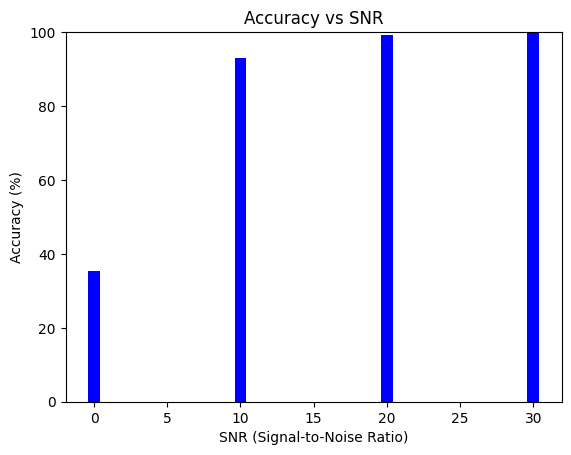

In [50]:
# Qualification des performances selon SNR


predicted_labels = []
for sublist in predicted_labels_total:
    predicted_labels.extend([tensor.item() for tensor in sublist])

indices_snr_0 = [i for i, snr in enumerate(test_snr) if snr == 0]
indices_snr_10 = [i for i, snr in enumerate(test_snr) if snr == 10]
indices_snr_20 = [i for i, snr in enumerate(test_snr) if snr == 20]
indices_snr_30 = [i for i, snr in enumerate(test_snr) if snr == 30]

predicted_labels = np.array(predicted_labels)

# Accuracy pour SNR 0
correct_predictions_snr_0 = (np.array(predicted_labels[indices_snr_0]) == np.array(test_labels_id[indices_snr_0])).sum().item()
total_samples_snr_0 = len(indices_snr_0)
accuracy_snr_0 = correct_predictions_snr_0 / total_samples_snr_0 * 100.0
print(f"Test accuracy, SNR 0: {accuracy_snr_0:.2f}%")

# Accuracy pour SNR 10
correct_predictions_snr_10 = (np.array(predicted_labels[indices_snr_10]) == np.array(test_labels_id[indices_snr_10])).sum().item()
total_samples_snr_10 = len(indices_snr_10)
accuracy_snr_10 = correct_predictions_snr_10 / total_samples_snr_10 * 100.0
print(f"Test accuracy, SNR 10: {accuracy_snr_10:.2f}%")

# Accuracy pour SNR 20
correct_predictions_snr_20 = (np.array(predicted_labels[indices_snr_20]) == np.array(test_labels_id[indices_snr_20])).sum().item()
total_samples_snr_20 = len(indices_snr_20)
accuracy_snr_20 = correct_predictions_snr_20 / total_samples_snr_20 * 100.0
print(f"Test accuracy, SNR 20: {accuracy_snr_20:.2f}%")

# Accuracy pour SNR 30
correct_predictions_snr_30 = (np.array(predicted_labels[indices_snr_30]) == np.array(test_labels_id[indices_snr_30])).sum().item()
total_samples_snr_30 = len(indices_snr_30)
accuracy_snr_30 = correct_predictions_snr_30 / total_samples_snr_30 * 100.0
print(f"Test accuracy, SNR 30: {accuracy_snr_30:.2f}%")


snr_levels = [0, 10, 20, 30]
accuracies = [accuracy_snr_0, accuracy_snr_10, accuracy_snr_20, accuracy_snr_30]

# Create a bar graph
plt.bar(snr_levels, accuracies, color='blue')
plt.xlabel('SNR (Signal-to-Noise Ratio)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs SNR')
plt.ylim(0, 100)
plt.show()

<font color="blue"> Les résultats obtenus sont cohérents avec ce que l'on attendait: seulement 35.41% des signaux avec un SNR = 0 sont bien classés, alors que presque tous les signaux avec un SNR = 20 et SNR = 30 sont bien classés. Plus le SNR est élevé, plus c'est facile d'identifier à quelle classe appartient chaque signal.

<font color="blue"> On va finalement présenter les matrices de confusion pour chaque SNR.

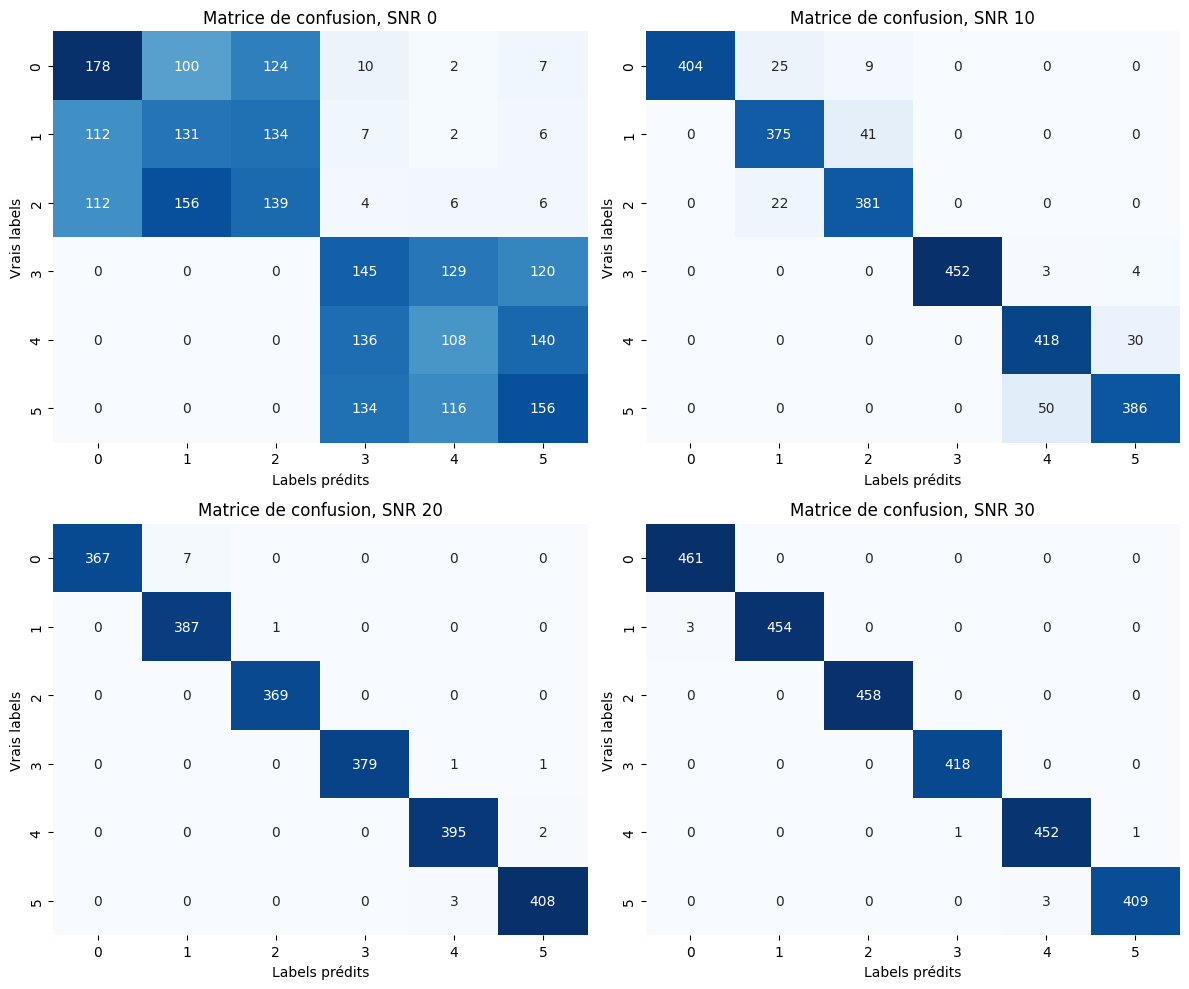

In [52]:
# Matrices de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns

test_labels_id_short = test_labels_id[0:1000]

conf_matrix_snr_0 = confusion_matrix(test_labels_id[indices_snr_0], predicted_labels[indices_snr_0])
conf_matrix_snr_10 = confusion_matrix(test_labels_id[indices_snr_10], predicted_labels[indices_snr_10])
conf_matrix_snr_20 = confusion_matrix(test_labels_id[indices_snr_20], predicted_labels[indices_snr_20])
conf_matrix_snr_30 = confusion_matrix(np.array(predicted_labels[indices_snr_30]),np.array(test_labels_id[indices_snr_30]))

# On affiche les matrices de confusion
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_snr_0, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion, SNR 0')
plt.xlabel('Labels prédits')
plt.ylabel('Vrais labels')

plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_snr_10, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion, SNR 10')
plt.xlabel('Labels prédits')
plt.ylabel('Vrais labels')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_snr_20, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion, SNR 20')
plt.xlabel('Labels prédits')
plt.ylabel('Vrais labels')

plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_snr_30, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion, SNR 30')
plt.xlabel('Labels prédits')
plt.ylabel('Vrais labels')

plt.tight_layout()
plt.show()

<font color="blue"> D'une part, on observe que les matrices obtenues sont cohérentes avec les accuracies obtenues selon le SNR dans la cellule précédente.  D'autre part, on observe un phénomène curieux: pour le SNR=0, on voit que l'on a deux clusters de signaux bien différenciés par notre modèle: ceux des classes 0, 1 et 2 et ceux des classes 3, 4 et 5 (par exemple, si le réseau attribue la classe 0, 1 ou 2 à un signal, alors il appartient forcément à une de ces trois classes).